# Titanic Jupyter Notebooks Project

## Step 1 Get The Data

The data has been pre downloaded and placed in the datasets directory.


In [147]:
import os
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier


In [148]:
DATA_PATH = "datasets"

def load_titanic_training_data(path=DATA_PATH):
    csv_path = os.path.join(path, "train.csv")
    return pd.read_csv(csv_path)
def load_titanic_test_data(path=DATA_PATH):
    csv_path = os.path.join(path, "test.csv")
    return pd.read_csv(csv_path)

### Now let's look at the data

In [149]:
titanic = load_titanic_training_data()
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Each row represents one passenger. There are 10 attributes(columns). 
Survived: Survival, 0 = No, 1 = Yes; 
Pclass: Ticket class, 1 = first class, 2 = second class, 3 = third class; Sex: sex; 
Age: age; 
SibSp: # of sibilings / spouse aboard; 
Parch: # of parents / children aboard; 
Ticket: ticket number; 
Fare: passenger fare; 
Cabin: Cabin number; 
Embarked: port of embarkation, C = Cherbourg, Q = Queenstown, S = Southampton.

In [150]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [151]:
titanic["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [152]:
titanic["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [153]:
titanic["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [154]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [155]:
titanic[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [156]:
titanic[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


## Few points to note here:

- Around 38% samples survived representative of the actual historical survival rate of 32%.
- Most passengers (> 75%) did not travel with parents or children.
- There are very few elderly passengers within age of 65 and 80
- We can observe the correlation between passenger class 1 and survived, this will be included in the model                          
- We confirm the observation that female had a significant higher survival rate than male, this will be included in the model

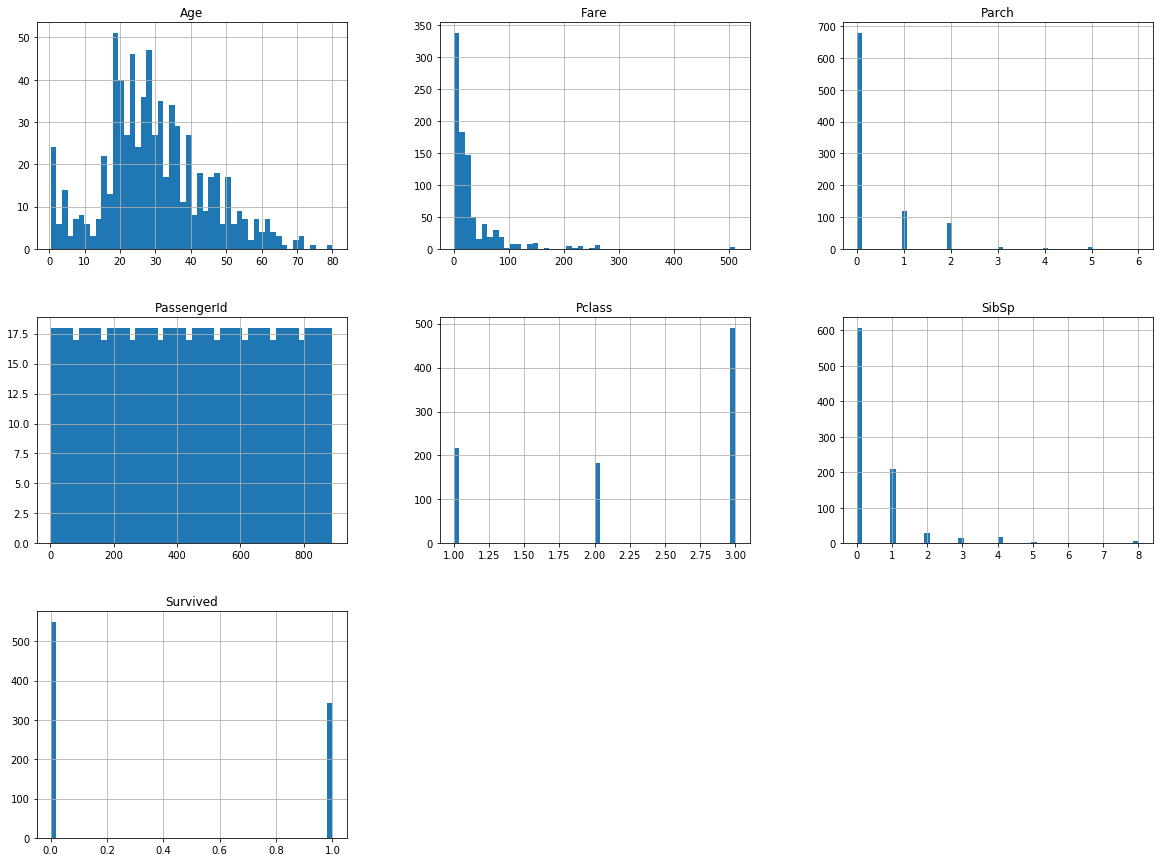

In [157]:
%matplotlib inline
titanic.hist(bins=50, figsize=(20,15))
plt.show()

### Correlations

In [158]:
corr_matrix = titanic.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

Ok some things to note here. 
* It seems like a higher fare corelates with a higher chance of survival but class has the oposite affect. This would be becuase lower classes like first class were better than third. 
* Having children or parents seemed to help your odds.
* PasengerID has no correlation really.
* Age and having siblings had a slight negative correlation.

### Let's try to focus on some attributes

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd93c1beb00>,
      dtype=object)

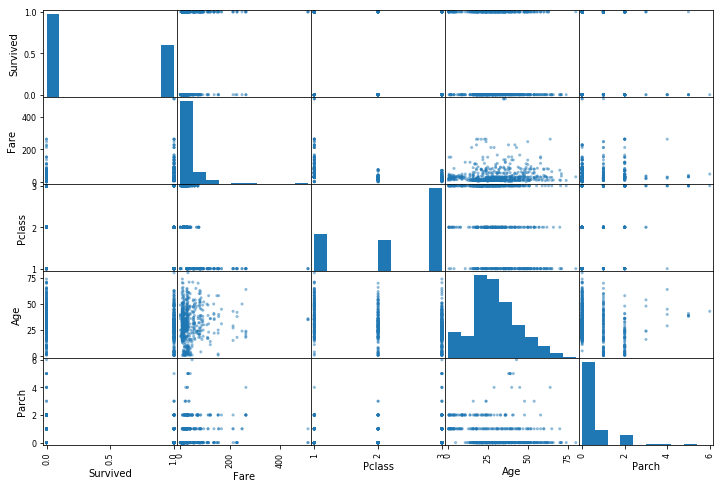

In [159]:
attributes = ["Survived", "Fare", "Pclass", "Age", "Parch"]

scatter_matrix(titanic[attributes], figsize=(12,8))

### This shows some results:
* Lower Class numbers are acociated with higher fares.
* Class 2/3 seemed to lean younger than Class 1.
* Fare and Class are not as tightly coupled as expected.

### More investigation into correlations needed

In [160]:
corr_matrix["Pclass"].sort_values(ascending=False)

Pclass         1.000000
SibSp          0.083081
Parch          0.018443
PassengerId   -0.035144
Survived      -0.338481
Age           -0.369226
Fare          -0.549500
Name: Pclass, dtype: float64

In [161]:
corr_matrix["Fare"].sort_values(ascending=False)

Fare           1.000000
Survived       0.257307
Parch          0.216225
SibSp          0.159651
Age            0.096067
PassengerId    0.012658
Pclass        -0.549500
Name: Fare, dtype: float64

In [162]:
corr_matrix["Age"].sort_values(ascending=False)

Age            1.000000
Fare           0.096067
PassengerId    0.036847
Survived      -0.077221
Parch         -0.189119
SibSp         -0.308247
Pclass        -0.369226
Name: Age, dtype: float64

In [163]:
corr_matrix["Parch"].sort_values(ascending=False)

Parch          1.000000
SibSp          0.414838
Fare           0.216225
Survived       0.081629
Pclass         0.018443
PassengerId   -0.001652
Age           -0.189119
Name: Parch, dtype: float64

I wonder how these new factors coorelate.

In [164]:
corr_matrix = titanic.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

So having a cabin meant paying more, but any one from any class could have a cabin.

It seems that Fare is coorealated with Class and Age is negatively coorelated with Class but not very correlated with Fare. I suspect that this has to do with Fares for children being less than adults regardless of class.

## Data Prep


It's going to be assumed that PassengerId, Name and Embarked have nothing to offer to our model. 
Ticket fare feature is dropped from our analysis as it contains high ratio of duplicates (22%) and there may not be a correlation between Ticket and survival.
Cabin feature is dropped as it is highly incomplete and contains many null values both in both data sets

We want to complete Age feature as it is definitely correlated to survival.

In [165]:
def clean_data(original):
    data = original.copy()
    data = data.drop(columns=["PassengerId", "Survived", "Name", "Ticket", "Cabin", "Embarked"])
    ##data["HasCabin"] = data["Cabin"].apply(lambda x: 1 if isinstance(x, str) == True else 0)
    ##data = data.drop("Cabin", axis=1)
    data["IsMale"] = data["Sex"].apply(lambda x: 1 if x == "male" else 0)
    data = data.drop("Sex", axis=1)
    data['Age'].fillna(value=data['Age'].mean(), inplace=True)
    return data

def clean_test_data(original):
    data = original.copy()
    data = data.drop(columns=["PassengerId", "Name", "Ticket", "Cabin", "Embarked"])
    ##data["HasCabin"] = data["Cabin"].apply(lambda x: 1 if isinstance(x, str) == True else 0)
    ##data = data.drop("Cabin", axis=1)
    data["IsMale"] = data["Sex"].apply(lambda x: 1 if x == "male" else 0)
    data = data.drop("Sex", axis=1)
    data['Age'].fillna(value=data['Age'].mean(), inplace=True)
    return data 

def get_clean_data():
    data = load_titanic_training_data()
    return clean_data(data)
    

train = get_clean_data()
train.head()
    
    

,Pclass,Age,SibSp,Parch,Fare,IsMale
0,3,22.0,1,0,7.2500,1
1,1,38.0,1,0,71.2833,0
2,3,26.0,0,0,7.9250,0
3,1,35.0,1,0,53.1000,0
4,3,35.0,0,0,8.0500,1


### Pipelines

In [166]:
class TitanicDataFramePipe(BaseEstimator, TransformerMixin):
    def __init__(self):
        return
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return clean_data(X).values
    
class TitanicTestDataFramePipe(BaseEstimator, TransformerMixin):
    def __init__(self):
        return
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return clean_test_data(X).values

In [167]:
pipeline = Pipeline([
    ('cleaner', TitanicDataFramePipe()),
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

test_pipeline = Pipeline([
    ('cleaner', TitanicTestDataFramePipe()),
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

titanic_train = load_titanic_training_data()
test = load_titanic_test_data()
test_t = test_pipeline.fit_transform(test)
prepared = pipeline.fit_transform(titanic_train)

In [168]:
def get_labels(original):
    return original["Survived"].copy()

labels = get_labels(titanic)

## Now it's time for model training!

In [178]:
lin_reg = LinearRegression()
lin_reg.fit(prepared, labels)

predictions = lin_reg.predict(prepared)

def get_rsme(predictions, labels):
    lin_mse = mean_squared_error(labels, predictions)
    lin_rmse = np.sqrt(lin_mse)
    return lin_rmse

get_rsme(predictions, labels)

0.37828982505545355

Naive Bayes Classifier

In [170]:
x_train, x_test, y_train, y_test = train_test_split(prepared, labels, test_size=0.25,shuffle=False)

gnb = GaussianNB()
gnb.fit(x_train,y_train)
predictions = gnb.predict(x_test)

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print(accuracy_score(y_test, predictions))


[[122  19]
 [ 26  56]]
              precision    recall  f1-score   support

           0       0.82      0.87      0.84       141
           1       0.75      0.68      0.71        82

   micro avg       0.80      0.80      0.80       223
   macro avg       0.79      0.77      0.78       223
weighted avg       0.80      0.80      0.80       223

0.7982062780269058


In [171]:
gnb.fit(prepared,labels)
predictions = gnb.predict(test_t)

test_final = test.copy()[['PassengerId']]
test_final['Survived'] = predictions
test_final.to_csv('titanic_gnb_prediction.csv', index=False)
test_final.head(15)

,PassengerId,Survived
count,418.000000,418.000000
mean,1100.500000,0.397129
std,120.810458,0.489890
min,892.000000,0.000000
25%,996.250000,0.000000
50%,1100.500000,0.000000
75%,1204.750000,1.000000
max,1309.000000,1.000000


Perceptron

In [173]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)

predictions = clf.fit(prepared, labels).predict(prepared)
score = accuracy_score(labels,predictions)
get_rsme(predictions, labels)
print(score)

0.8215488215488216


In [179]:
predictions = clf.predict(test_t)
test_final = test.copy()[['PassengerId']]
test_final['Survived'] = predictions
test_final.to_csv('titanic_mlp_prediction.csv', index=False)
test_final.head(15)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0
